https://github.com/DataTalksClub/mlops-zoomcamp/blob/main/cohorts/2024/05-monitoring/homework.md

The goal of this homework is to familiarize users with monitoring for ML batch services, using PostgreSQL database to store metrics and Grafana to visualize them.

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
def read_data(color, year, month):
    color = 'green'
    year = 2024
    month=3
    url = f'https://d37ci6vzurychx.cloudfront.net/trip-data/{color}_tripdata_{year:04d}-{month:02d}.parquet'
    df = pd.read_parquet(url)
    print(df.shape)
    return df

# Q1. Prepare the dataset

Start with `baseline_model_nyc_taxi_data.ipynb`. Download the March 2024 Green Taxi data. We will use this data to simulate a production usage of a taxi trip duration prediction service.

What is the shape of the downloaded data? How many rows are there?

In [3]:
df_mar = read_data('green', 2024, 3)
df_mar.head()

(57457, 20)


,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2024-03-01 00:10:52,2024-03-01 00:26:12,N,1.0,129,226,1.0,1.72,12.8,1.0,0.5,3.06,0.0,NaN,1.0,18.36,1.0,1.0,0.00
1,2,2024-03-01 00:22:21,2024-03-01 00:35:15,N,1.0,130,218,1.0,3.25,17.7,1.0,0.5,0.00,0.0,NaN,1.0,20.20,2.0,1.0,0.00
2,2,2024-03-01 00:45:27,2024-03-01 01:04:32,N,1.0,255,107,2.0,4.58,23.3,1.0,0.5,3.50,0.0,NaN,1.0,32.05,1.0,1.0,2.75
3,1,2024-03-01 00:02:00,2024-03-01 00:23:45,N,1.0,181,71,1.0,0.00,22.5,0.0,1.5,0.00,0.0,NaN,1.0,24.00,1.0,1.0,0.00
4,2,2024-03-01 00:16:45,2024-03-01 00:23:25,N,1.0,95,135,1.0,1.15,8.6,1.0,0.5,1.00,0.0,NaN,1.0,12.10,1.0,1.0,0.00


Answer: __57457__

# Q2. Metric

Let's expand the number of data quality metrics we’d like to monitor! Please add one metric of your choice and a quantile value for the "fare_amount" column (quantile=0.5).

Hint: explore evidently metric ColumnQuantileMetric (from evidently.metrics import ColumnQuantileMetric)

What metric did you choose?

Answer: __ColumnCorrelationsMetric__

# Q3. Monitoring

Let’s start monitoring. Run expanded monitoring for a new batch of data (March 2024).

What is the maximum value of metric quantile = 0.5 on the "fare_amount" column during March 2024 (calculated daily)?

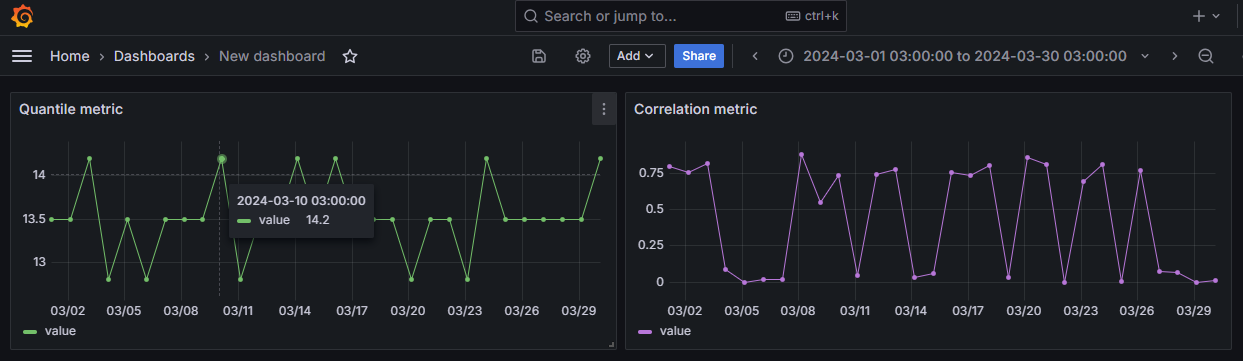

Answer: __14.2__

# Q4. Dashboard

Finally, let’s add panels with new added metrics to the dashboard. After we customize the dashboard let's save a dashboard config, so that we can access it later. 

Hint: click on “Save dashboard” to access JSON configuration of the dashboard. This configuration should be saved locally.

Where to place a dashboard config file?

Answer: __project_folder/dashboards__